In [44]:
# import seaborn
import seaborn as sns
import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt


# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

In [45]:
def convert_to_datetime(df):
  df['tidspunkt'] = pd.to_datetime(df['tidspunkt'], dayfirst=True)
  df['ank_hentested'] = pd.to_datetime(df['ank_hentested'], dayfirst=True)
  return df

In [47]:
df = pd.read_csv("proprietary_data/processed_distribution.csv")

df.loc[df["hastegrad"] == 'V1', "hastegrad"] = 'V'
df.loc[df["hastegrad"] == 'V2', "hastegrad"] = 'V'
df = convert_to_datetime(df)
df["date"] = pd.to_datetime(df["tidspunkt"]).dt.date
df["response_time"] = (df["ank_hentested"] - df["tidspunkt"]).dt.total_seconds()

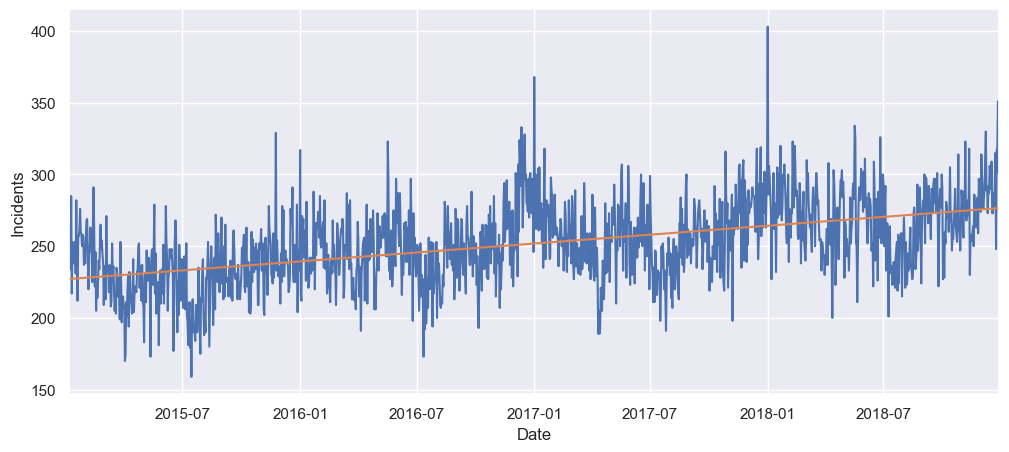

In [48]:
start = datetime(2015, 1, 5, 0, 0, 0)
end = datetime(2018, 12, 30, 0, 0, 0)

df_filtered = df.loc[(df['tidspunkt'] >= start) & (df['tidspunkt'] <= end)]

# Group the incidents by date and count the number of incidents per date
incidents_by_date = df_filtered.groupby(df["tidspunkt"].dt.date).size().reset_index(name="count")

trend = np.polyfit(range(len(incidents_by_date)), incidents_by_date["count"], 1)
line = np.poly1d(trend)

# Create the line plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
ax.set_xlim(left=incidents_by_date["tidspunkt"].iloc[0], right=incidents_by_date["tidspunkt"].iloc[-1])
ax.plot(incidents_by_date["tidspunkt"], incidents_by_date["count"])
ax.plot(incidents_by_date["tidspunkt"], line(range(len(incidents_by_date))))
ax.set_xlabel("Date")
ax.set_ylabel("Incidents")
plt.show()

C:\Users\erikm\AppData\Local\Temp\ipykernel_6236\2457586549.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  incidents_by_doy = incidents_by_date.groupby(incidents_by_date["date"].apply(lambda x: x.timetuple().tm_yday)).mean().reset_index()


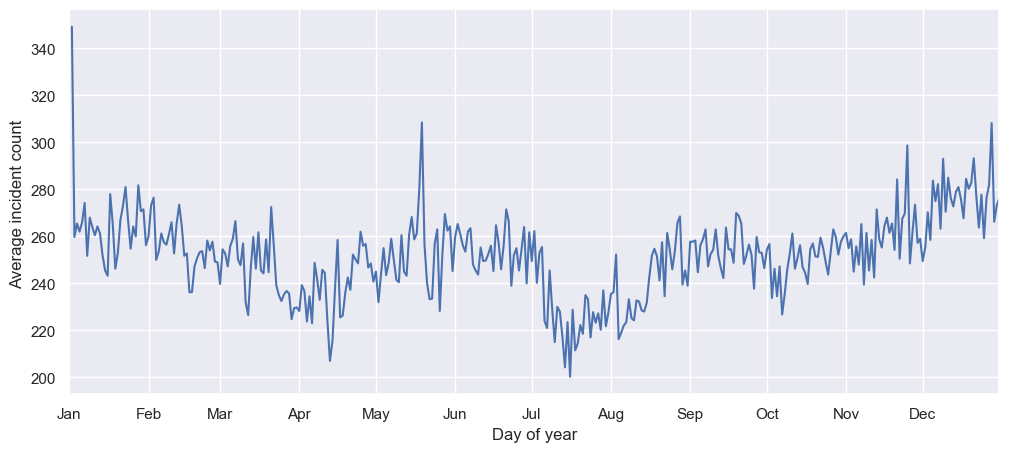

In [49]:
import matplotlib.dates as mdates

# Group the incidents by date and count the number of incidents per date
incidents_by_date = df.groupby("date").size().reset_index(name="count")

# Group the incidents by day of year and calculate the average number of incidents per day of year
incidents_by_doy = incidents_by_date.groupby(incidents_by_date["date"].apply(lambda x: x.timetuple().tm_yday)).mean().reset_index()

# Create the line plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
ax.set_xlim(0, 364)
ax.plot(incidents_by_doy["date"], incidents_by_doy["count"])
ax.set_xlabel("Day of year")
ax.set_ylabel("Average incident count ")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

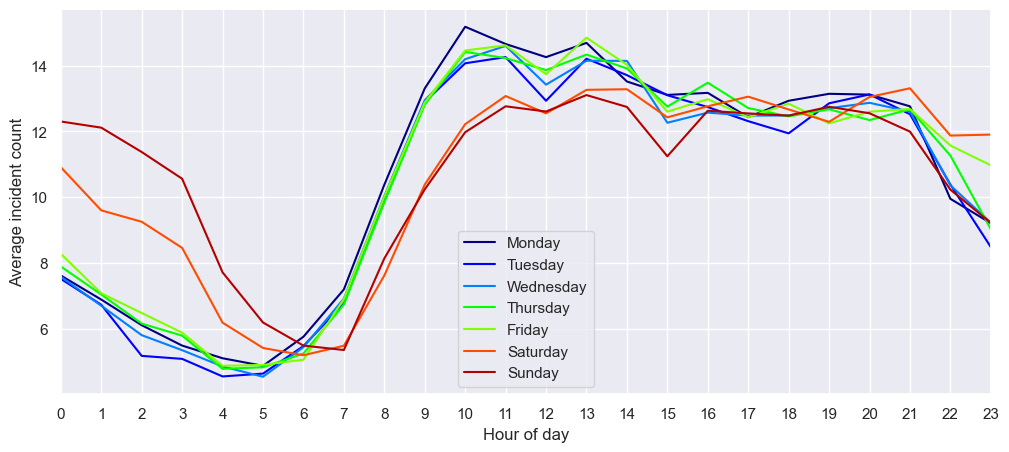

In [50]:
import calendar
from matplotlib.colors import LinearSegmentedColormap

# Create a new column for the hour of each incident
df["hour"] = df["tidspunkt"].dt.hour

# Group incidents by weekday and hour, and calculate the average count per hour
incidents_by_weekday_hour = df.groupby([df["tidspunkt"].dt.weekday, "hour"]).size().reset_index(name="count")
incidents_by_weekday_hour["mean"] = incidents_by_weekday_hour["count"] / (52*4)
incidents_by_weekday_hour["weekday"] = incidents_by_weekday_hour["tidspunkt"].apply(lambda x: calendar.day_name[x])

# Pivot the data to get a table with weekdays as columns and hours as rows
incidents_by_weekday_hour_pivot = incidents_by_weekday_hour.pivot(index="hour", columns="weekday", values="mean")

# Sort the columns of the pivot table
incidents_by_weekday_hour_pivot = incidents_by_weekday_hour_pivot.reindex(columns=calendar.day_name)

# Define a custom colormap
cmap = LinearSegmentedColormap.from_list('my_cmap', [(0, 0, 0.5), (0, 0, 1), (0, 0.5, 1), (0, 1, 0), (0.5, 1, 0), (1, 0.3, 0), (0.7, 0, 0)], N=7)

# Create the line plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
for i, day in enumerate(incidents_by_weekday_hour_pivot):
    vals = incidents_by_weekday_hour_pivot[day]
    clr = cmap(np.linspace(0, 1, 7)[i])
    ax.plot(vals, label=day, color=clr)
ax.set_xlim(0, 23)
ax.set_xlabel("Hour of day")
ax.set_ylabel("Average incident count")
ax.legend(incidents_by_weekday_hour_pivot.columns)
# Set the x-ticks
ax.set_xticks(range(24))
plt.show()

C:\Users\erikm\AppData\Local\Temp\ipykernel_5148\2847308833.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  incidents_by_dow_hour = incidents_by_date_hour.groupby([incidents_by_date_hour["tidspunkt"].apply(lambda x: x.weekday()), "hour"]).mean().reset_index()
C:\Users\erikm\AppData\Local\Temp\ipykernel_5148\2847308833.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


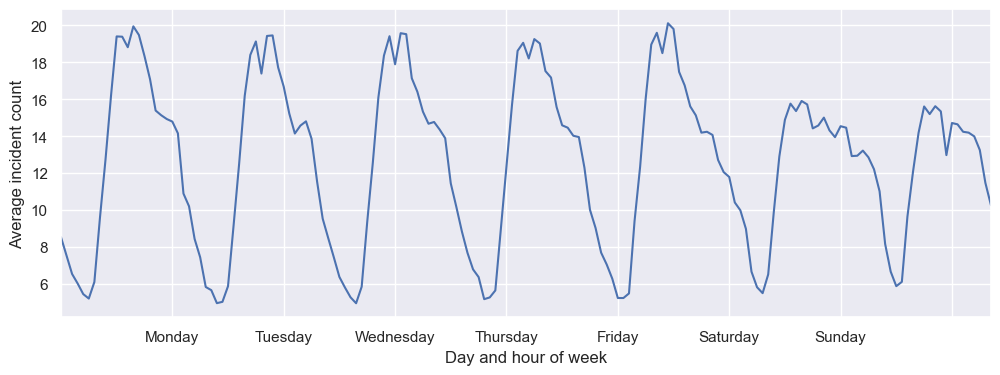

In [55]:
import matplotlib.dates as mdates

# Create a new column for the hour of each incident
df["hour"] = df["tidspunkt"].dt.hour

# Group the incidents by date and hour and count the number of incidents per date and hour
incidents_by_date_hour = df.groupby([df["tidspunkt"].dt.date, "hour"]).size().reset_index(name="count")

# Group the incidents by day of week and hour and calculate the average number of incidents per day of week and hour
incidents_by_dow_hour = incidents_by_date_hour.groupby([incidents_by_date_hour["tidspunkt"].apply(lambda x: x.weekday()), "hour"]).mean().reset_index()

# Create the line plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

# Set x-axis ticks and labels
xticklabels = ["", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plot the data
ax.plot(incidents_by_dow_hour["count"])
ax.set_xlim(0, 167)
ax.set_xticklabels(xticklabels)
ax.set_xlabel("Day and hour of week")
ax.set_ylabel("Average incident count")

plt.show()

In [ ]:
df_lim = df[df["hastegrad"] == "A"]
df_lim = df_lim[df_lim['response_time'].notna()]
response_times = df_lim["response_time"] / 60

median = np.median(response_times)
average = np.mean(response_times)
percentile90 = np.percentile(response_times, 90)

print(median, average, percentile90)

9.9 11.570876091359247 18.75


[Text(0.5, 0, 'Response time '), Text(0, 0.5, 'Incidents')]

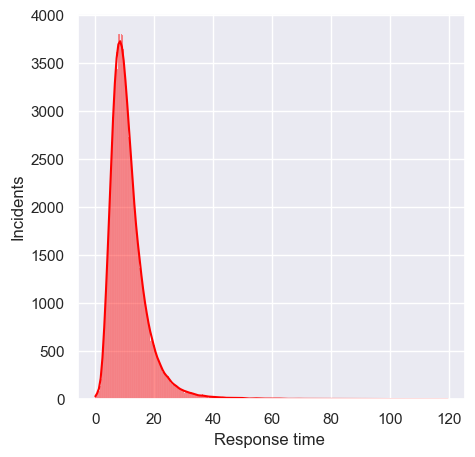

In [6]:
df_lim = df[df["response_time"] < 60 * 120]
df_lim = df_lim[df_lim['response_time'].notna()]

df_lim = df_lim[df_lim["hastegrad"] == "A"]

response_times = df_lim["response_time"] / 60

ax = sns.histplot(response_times, kde=True, color='red')
ax.set(xlabel='Response time ', ylabel='Incidents')

In [27]:
df = pd.read_csv("proprietary_data/incidents_processed_2.csv", encoding='utf-8', escapechar='\\')

df[df["hastegrad"] == 'V1'] = 'V'
df[df["hastegrad"] == 'V2'] = 'V'
df = df[df['hastegrad'].notna()]

urgency = df["hastegrad"]
urgency = urgency.sort_values()


[Text(0.5, 0, 'Urgency'), Text(0, 0.5, 'Incidents')]

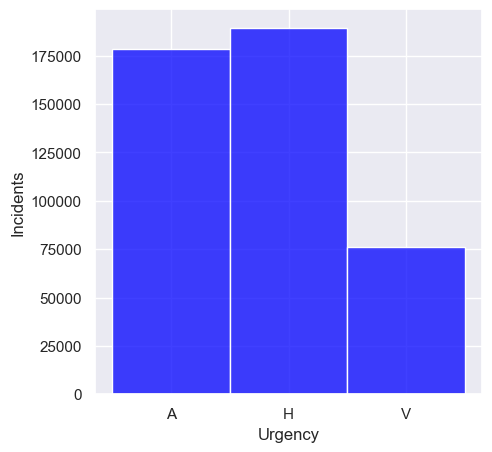

In [28]:
ax = sns.histplot(urgency, kde=False, color='blue')
ax.set(xlabel='Urgency', ylabel='Incidents')

[Text(0.5, 0, 'Distribution '), Text(0, 0.5, 'Incidents')]

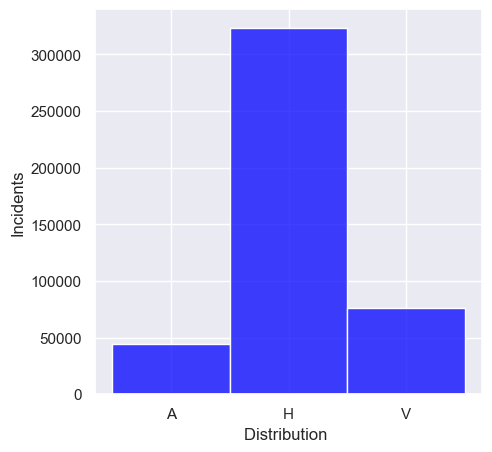

In [31]:
urgency_preset = []
for u in urgency:
    if u == 'A':
        u = np.random.choice(['A', 'H'], p=[1/4, 3/4])
    urgency_preset.append(u)

urgency_preset.sort()
urgency_preset = pd.Series(urgency_preset)

ax = sns.histplot(urgency_preset, kde=False, color='blue')
ax.set(xlabel='Distribution ', ylabel='Incidents')

[Text(0.5, 0, 'Urgency'), Text(0, 0.5, 'Incidents')]

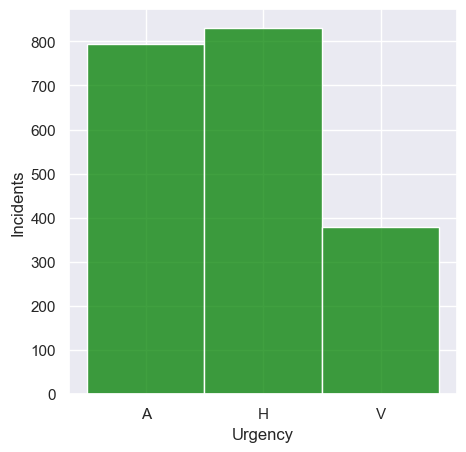

In [32]:
df_sim = pd.read_csv("C:/Users/erikm/Documents/Studie/Master/ambulance-optimization/output/simulation/simple_response_times_pop_prop.csv")

df_sim[df_sim["urgency"] == 'V1'] = 'V'
df_sim[df_sim["urgency"] == 'V2'] = 'V'
urgency_sim = df_sim["urgency"]

ax = sns.histplot(urgency_sim, kde=False, color='green')
ax.set(xlabel='Urgency', ylabel='Incidents')


[Text(0.5, 0, 'Distribution '), Text(0, 0.5, 'Incidents')]

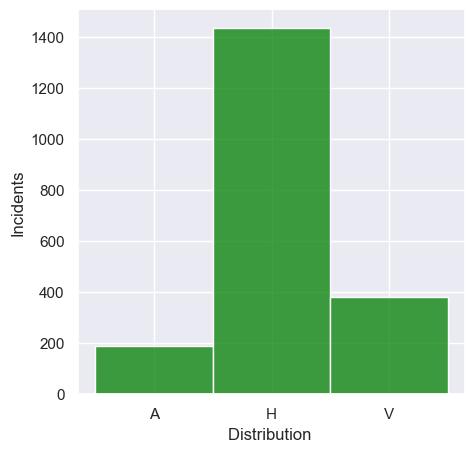

In [33]:
urgency_sim_preset = []
for u in urgency_sim:
    if u == 'A':
        u = np.random.choice(['A', 'H'], p=[1/4, 3/4])
    urgency_sim_preset.append(u)

urgency_sim_preset.sort()
urgency_sim_preset = pd.Series(urgency_sim_preset)

ax = sns.histplot(urgency_sim_preset, kde=False, color='green')
ax.set(xlabel='Distribution ', ylabel='Incidents')

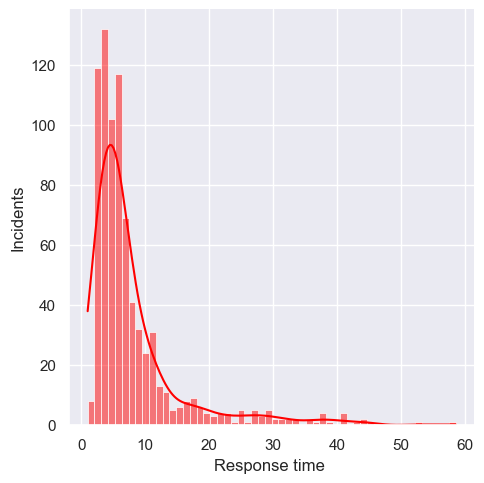

In [4]:
df_sim_A = df_sim[df_sim["urgency"] == "A"]

response_sim_A = df_sim_A["response_time"] / 60

ax = sns.displot(response_sim_A, kde=True, color='red')
ax.set(xlabel='Response time ', ylabel='Incidents')

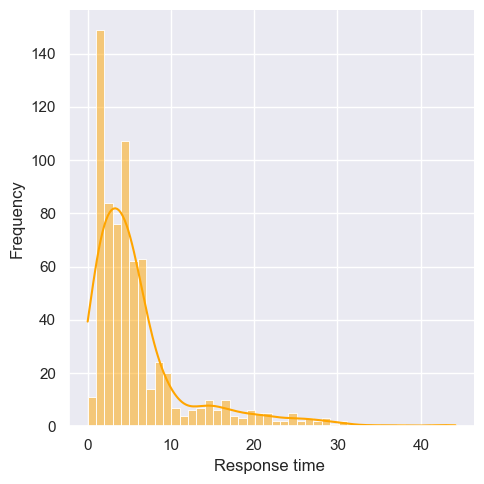

In [134]:
df_sim_H = df_sim[df_sim["urgency"] == "H"]

response_sim_H = df_sim_H["pop_prop_response"] / 60

ax = sns.displot(response_sim_H, kde=True, color='orange')
ax.set(xlabel='Response time ', ylabel='Frequency')

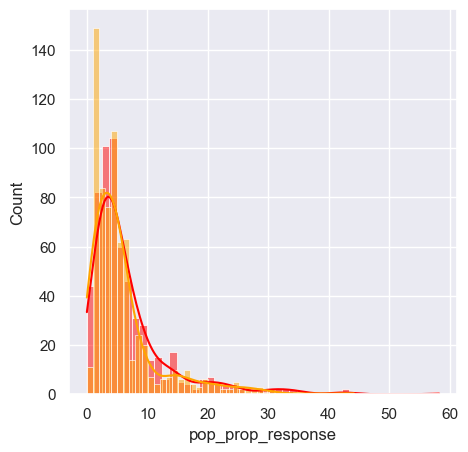

In [135]:
import matplotlib.pyplot as plt

sns.histplot(response_sim_A, kde=True, color='red')
sns.histplot(response_sim_H, kde=True, color='orange')
plt.show()

(0.0, 200.0)

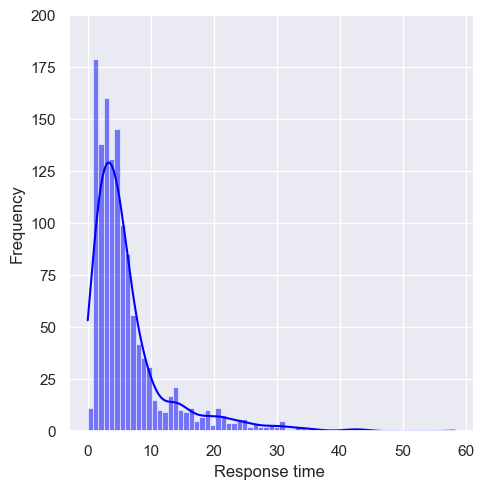

In [43]:
df_sim = pd.read_csv("C:/Users/erikm/Documents/Master/ambulance-optimization/output/simulation/urgency_incidents.csv")

df_sim_A = df_sim[df_sim["urgency"] == "A"]

response_sim_A = df_sim["pop_prop_response"] / 60

ax = sns.displot(response_sim_A, kde=True, color='blue')
ax.set(xlabel='Response time ', ylabel='Frequency')
plt.ylim(0, 200)


(0.0, 160.0)

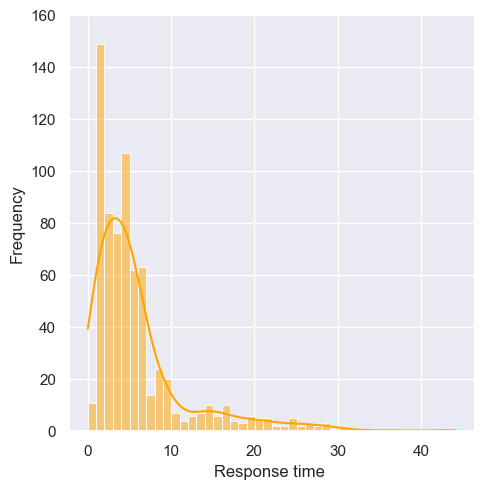

In [15]:
df_sim_H = df_sim[df_sim["urgency"] == "H"]

response_sim_H = df_sim_H["pop_prop_response"] / 60

ax = sns.displot(response_sim_H, kde=True, color='orange')
ax.set(xlabel='Response time ', ylabel='Frequency')
plt.ylim(0, 160)

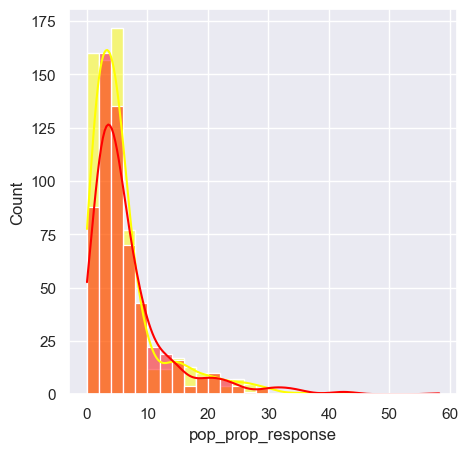

In [132]:
sns.histplot(response_sim_H, bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], kde=True, color='yellow')
sns.histplot(response_sim_A, bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], kde=True, color='red')

plt.show()

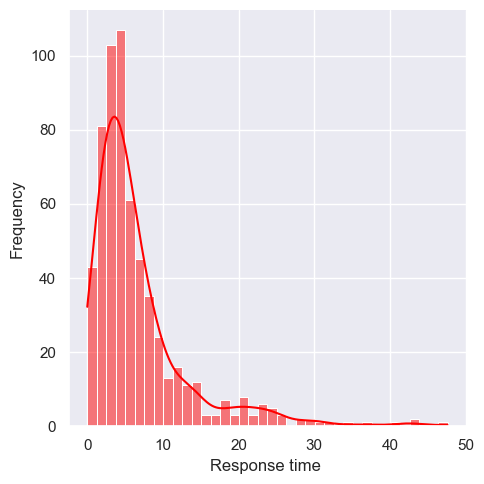

In [139]:
df_sim = pd.read_csv("C:/Users/erikm/Documents/Master/ambulance-optimization/output/simulation/dispatch_urgency_incidents.csv")

df_sim_A = df_sim[df_sim["urgency"] == "A"]

response_sim_A = df_sim_A["pop_prop_response"] / 60

ax = sns.displot(response_sim_A, kde=True, color='red')
ax.set(xlabel='Response time ', ylabel='Frequency')


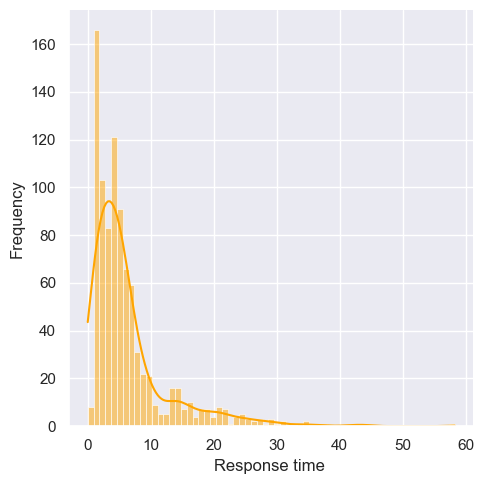

In [137]:
df_sim_H = df_sim[df_sim["urgency"] == "H"]

response_sim_H = df_sim_H["pop_prop_response"] / 60

ax = sns.displot(response_sim_H, kde=True, color='orange')
ax.set(xlabel='Response time ', ylabel='Frequency')

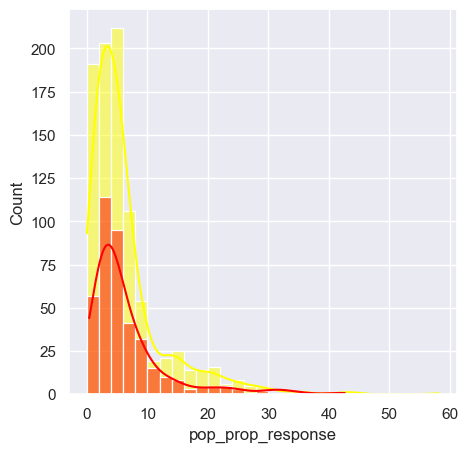

In [138]:
sns.histplot(response_sim_H, bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], kde=True, color='yellow')
sns.histplot(response_sim_A, bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], kde=True, color='red')

plt.show()

C:\Users\erikm\AppData\Local\Temp\ipykernel_6236\1656654232.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


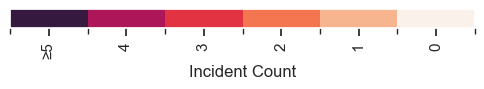

In [59]:
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import numpy as np

HEATMAP_COLORS = {
    '≥5':       '#35193E',
    '4':        '#AD1759',
    '3':        '#E13342',
    '2':        '#F37651',
    '1':        '#F6B48F',
    '0':        '#fbf1eb'
}

fig, ax = plt.subplots(figsize=(6, 0.5))
fig.subplots_adjust(bottom=0.5)

values = list(HEATMAP_COLORS.keys())
colors = list(HEATMAP_COLORS.values())

# Create a colormap from the colors
cmap = plt.cm.colors.ListedColormap(colors)

# Create a colorbar
bounds = np.linspace(0,len(values),len(values)+1)
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                  cax=ax,
                  orientation='horizontal',
                  ticks=np.linspace(0.5,len(values)-0.5,len(values)),
                  boundaries=bounds)

# Set the tick labels
cb.ax.set_xticklabels(values)
plt.xticks(rotation=90)

# Add a label to the colorbar
cb.set_label('Incident Count')

# Adjust the spacing between the tick labels
plt.tight_layout()

# Display the colorbar
plt.show()